## All You Need Is Linear Regression

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import graphviz as gr
from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

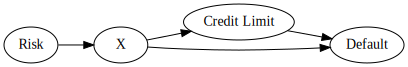

In [2]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Risk","X")
g_risk.edge("X","Credit Limit")
g_risk.edge("X", "Default")
g_risk.edge("Credit Limit", "Default")

g_risk

## Regression in A/B Tests

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv('./data/rec_ab_test.csv')
data.head()

,recommender,age,tenure,watch_time
0,challenger,15,1,2.39
1,challenger,27,1,2.32
2,benchmark,17,0,2.74
3,benchmark,34,1,1.92
4,benchmark,14,1,2.47


In [4]:
import statsmodels.formula.api as smf

result = smf.ols('watch_time ~ C(recommender)', data=data).fit()

result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.0491,0.058,35.367,0.000,1.935,2.163
C(recommender)[T.challenger],0.1427,0.095,1.501,0.134,-0.044,0.330


In [5]:
data.groupby("recommender")["watch_time"].mean()

recommender
benchmark     2.049064
challenger    2.191750
Name: watch_time, dtype: float64

## Adjusting with Regression

In [6]:
risk_data = pd.read_csv('./data/risk_data.csv')
risk_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,default
0,950.0,11,16,1,500.0,518.0,3200.0,0
1,780.0,11,7,1,414.0,429.0,1700.0,0
2,1230.0,14,9,1,586.0,571.0,4200.0,0
3,1040.0,15,8,1,379.0,411.0,1500.0,0
4,1000.0,16,1,1,379.0,518.0,1800.0,0


In [7]:
model = smf.ols('default ~ credit_limit', data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2192,0.004,59.715,0.000,0.212,0.226
credit_limit,-2.402e-05,1.16e-06,-20.689,0.000,-2.63e-05,-2.17e-05


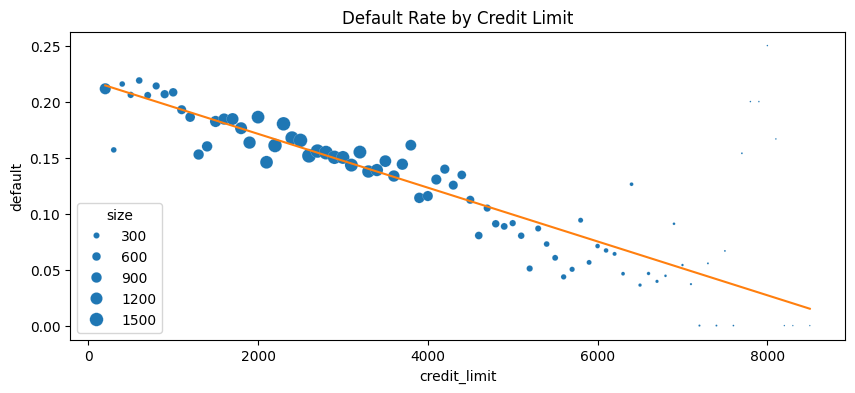

In [8]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default":"mean", "size":sum})
          .reset_index()
          .assign(prediction = lambda d: model.predict(d)))

plt.figure(figsize=(10,4))

sns.scatterplot(data = plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit"], plt_df["prediction"], color="C1")
plt.title("Default Rate by Credit Limit")

plt.show()

In [9]:
risk_data.groupby(["credit_score1","credit_score2"]).size().head()

credit_score1  credit_score2
34.0           339.0            1
               500.0            1
52.0           518.0            1
69.0           214.0            1
               357.0            1
dtype: int64

In [10]:
formula = 'default ~ credit_limit + wage + credit_score1 + credit_score2'
model = smf.ols(formula, data=risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


## Regression Theory

In [11]:
X_cols = ["credit_limit","wage","credit_score1","credit_score2"]
X = risk_data[X_cols].assign(intercep=1)
y = risk_data["default"]

def regress(y, X):
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([ 3.06252773e-06, -8.82159125e-05, -4.17472814e-05, -3.03928359e-04,
        4.03661277e-01])

## Frisch-Waugh-Lovell Theorem and Orthogonalization

In [12]:
formula = 'default ~ credit_limit + wage + credit_score1 + credit_score2'
model = smf.ols(formula, data = risk_data).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4037,0.009,46.939,0.000,0.387,0.421
credit_limit,3.063e-06,1.54e-06,1.987,0.047,4.16e-08,6.08e-06
wage,-8.822e-05,6.07e-06,-14.541,0.000,-0.000,-7.63e-05
credit_score1,-4.175e-05,1.83e-05,-2.278,0.023,-7.77e-05,-5.82e-06
credit_score2,-0.0003,1.52e-05,-20.055,0.000,-0.000,-0.000


## Debiasing Step

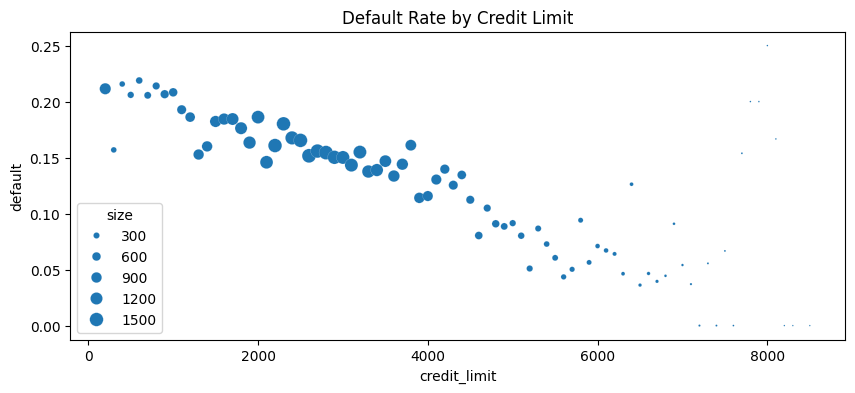

In [13]:
plt_df = (risk_data
          .assign(size=1)
          .groupby("credit_limit")
          .agg({"default":"mean", "size":sum})
          .reset_index())
plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit",
                y="default",
                size="size",
                sizes=(1,100))
plt.title("Default Rate by Credit Limit")
plt.show()

In [14]:

# create the debiasing model to predict the credit limit
# based on other confounding variables
formula = "credit_limit ~ wage + credit_score1 + credit_score2"
debiasing_model = smf.ols(formula, data=risk_data).fit()

# assign the variable credit_limit_res the residuals 
# from the debiased model plus the average credit limit

# the add the credit_limit_res to the risk_data dataframe
# and called the new dataframe risk_data_deb
risk_data_deb = risk_data.assign(
    credit_limit_res=(debiasing_model.resid
                      + risk_data["credit_limit"].mean()))

In [15]:
# build a simple regression model to predict the default value
# based on the credit_limit_res field that was added to the
# new dataframe risk_data_deb

# notice hos the credit_limit_res coef is the same as the
# credit_limit coef in the bigger model
model_w_deb_data = smf.ols("default ~ credit_limit_res",
                           data = risk_data_deb).fit()
model_w_deb_data.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.001,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.56e-06,1.957,0.050,-4.29e-09,6.13e-06


Text(0.5, 1.0, 'Default Rate by Debiased Credit Limit')

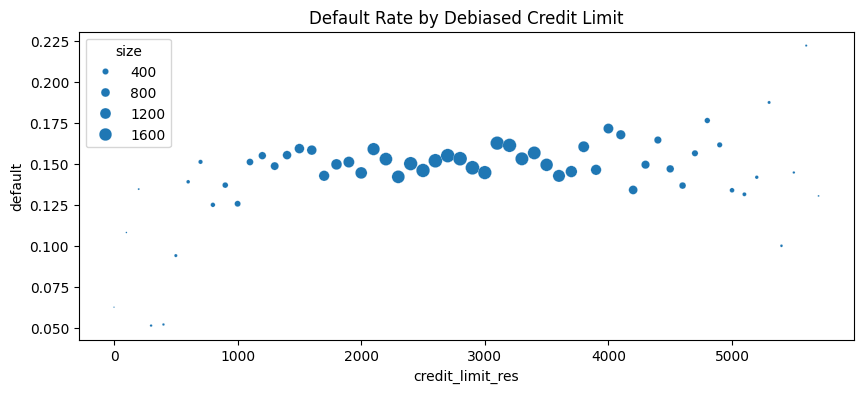

In [16]:
# notice how the graph is no longer downward sloping
# as when the data was biased

plt_df = (risk_data_deb
         .assign(size=1)
         .assign(credit_limit_res = lambda d : d["credit_limit_res"].round(-2))
         .groupby("credit_limit_res")
         .agg({"default":"mean", "size":sum})
         .query("size>30")
         .reset_index())

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default",
                size="size",
                sizes=(1,100))

plt.title("Default Rate by Debiased Credit Limit")

## Denoising Step

In [17]:
# use the risk_data_deb dataframe from the debiasing step
formula = "default ~ wage + credit_score1 + credit_score2"
denoising_model  =smf.ols(formula, data = risk_data_deb).fit()

denoising_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4035,0.009,46.924,0.000,0.387,0.420
wage,-8.259e-05,5.36e-06,-15.395,0.000,-9.31e-05,-7.21e-05
credit_score1,-3.595e-05,1.81e-05,-1.987,0.047,-7.14e-05,-4.81e-07
credit_score2,-0.0003,1.52e-05,-20.037,0.000,-0.000,-0.000


In [18]:
risk_data_denoise = risk_data_deb.assign(
    default_res = denoising_model.resid + 
                risk_data_deb["default"].mean())

## Standard Error of the Regression Estimator

In [19]:
formula = "default ~ wage + credit_score1 + credit_score2"
model_se = smf.ols(formula, data = risk_data).fit()
print("SE regression:", model_se.bse["wage"])

formula = "wage ~ credit_score1 + credit_score2"
model_wage_aux = smf.ols(formula, data = risk_data).fit()

se_formula = (np.std(model_se.resid)
             / (np.std(model_wage_aux.resid)*np.sqrt(len(risk_data)-4)))

print("SE formula: ", se_formula)

SE regression: 5.3642423475482495e-06
SE formula:  5.364242347548191e-06


## Final Outcome Model

In [20]:
# The parameter estimate for the treatment is eaxctly the same
# as the one you got in both the debiasing step and when running
# the regression model with credit limits plus all the other 
# covariates. Additionally, the standard error and p-value are 
# now also just like when you first ran the model with all the 
# variables included. This is the effect of the denoising step.

model_w_orthogonal = smf.ols('default_res ~ credit_limit_res',
                            data = risk_data_denoise).fit()
model_w_orthogonal.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1421,0.005,30.458,0.000,0.133,0.151
credit_limit_res,3.063e-06,1.54e-06,1.987,0.047,4.17e-08,6.08e-06


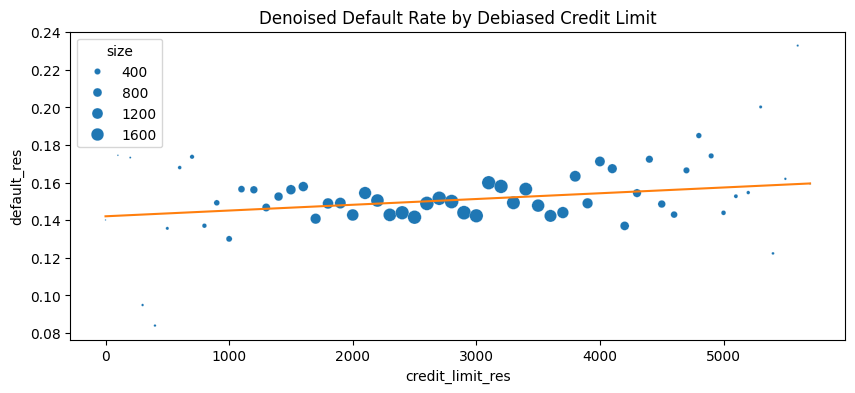

In [21]:
plt_df = (risk_data_denoise
          .assign(size=1)
          .assign(credit_limit_res = lambda d : d["credit_limit_res"].round(-2))
          .groupby("credit_limit_res")
          .agg({"default_res":"mean", "size":sum})
          .query("size>30")
          .reset_index()
          .assign(prediction = lambda d: model_w_orthogonal.predict(d)))

plt.figure(figsize=(10,4))
sns.scatterplot(data=plt_df,
                x="credit_limit_res",
                y="default_res",
                size="size",
                sizes=(1,100))

plt.plot(plt_df["credit_limit_res"], plt_df["prediction"], c="C1")

plt.title("Denoised Default Rate by Debiased Credit Limit")
plt.show()

## Positivity and Extrapolation

Text(0.5, 1.0, 'Dataset 2')

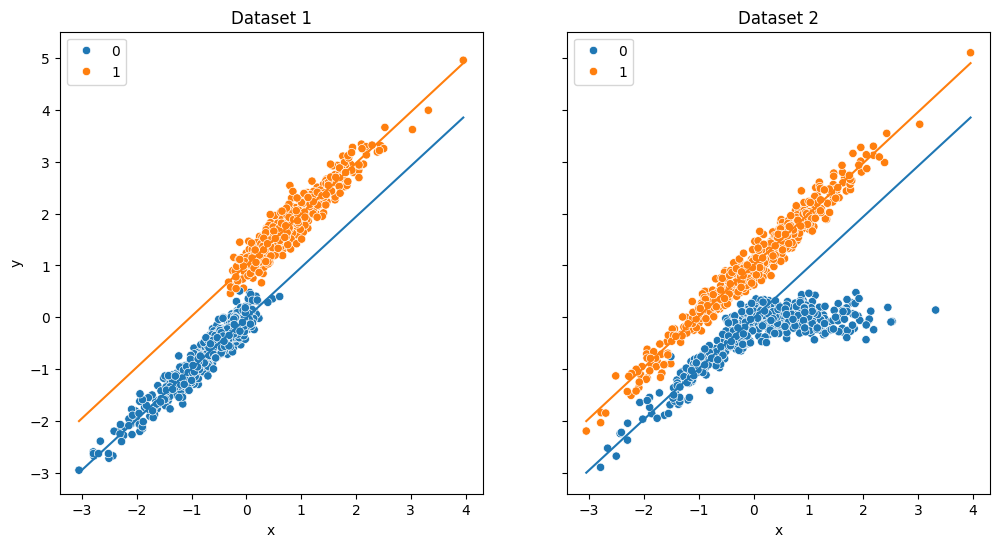

In [22]:
np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.normal(x, 0.2, n) > 0

y0 = x 
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_no_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

sns.scatterplot(data=df_no_pos, x="x", y="y", hue="t", ax=ax1)

m0 = smf.ols("y~x", data=df_no_pos.query(f"t==0")).fit()
m1 = smf.ols("y~x", data=df_no_pos.query(f"t==1")).fit()

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_no_pos)), x="x", y="pred", color=f"C0", ax=ax1)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_no_pos)), x="x", y="pred", color=f"C1", ax=ax1);
ax1.set_title("Dataset 1")

np.random.seed(1)

n = 1000
x = np.random.normal(0, 1, n)
t = np.random.binomial(1, 0.5, size=n)

y0 = x * (x<0) + (x>0)*0
y1 = 1 + x

y = np.random.normal((1-t)*y0 + t*y1, 0.2)

df_pos = pd.DataFrame(dict(x=x,t=t.astype(int),y=y))

sns.scatterplot(data=df_pos, x="x", hue="t", y="y", ax=ax2)

sns.lineplot(data=df_no_pos.assign(pred=m0.predict(df_pos)), x="x", y="pred", color=f"C0", ax=ax2)
sns.lineplot(data=df_no_pos.assign(pred=m1.predict(df_pos)), x="x", y="pred", color=f"C1", ax=ax2)
ax2.set_title("Dataset 2")



## Non-Linearities in Linear Regression

In [23]:
spend_data = pd.read_csv('./data/spend_data.csv')
spend_data.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_limit,spend
0,950.0,11,16,1,500.0,518.0,3200.0,3848
1,780.0,11,7,1,414.0,429.0,1700.0,3144
2,1230.0,14,9,1,586.0,571.0,4200.0,4486
3,1040.0,15,8,1,379.0,411.0,1500.0,3327
4,1000.0,16,1,1,379.0,518.0,1800.0,3508


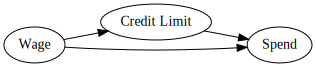

In [24]:
g_risk = gr.Digraph(graph_attr={"rankdir":"LR"})

g_risk.edge("Wage","Credit Limit")
g_risk.edge("Wage", "Spend")
g_risk.edge("Credit Limit", "Spend")

g_risk

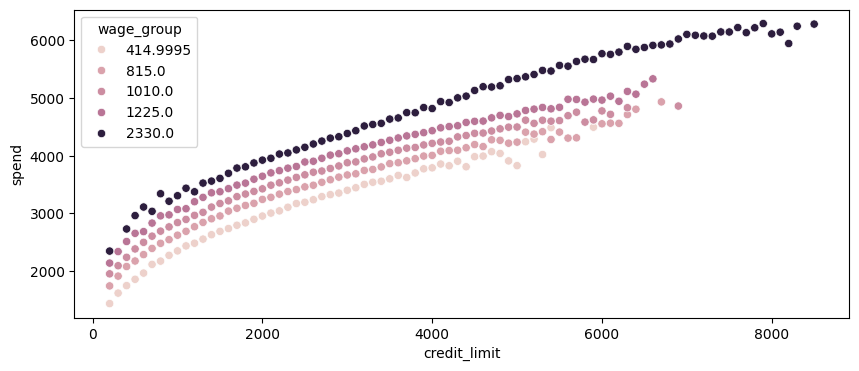

In [25]:
# wage groupgroups the wage in 5 buckets using pd.qcut()
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"],5)).mid)
          .groupby(["wage_group", "credit_limit"])[["spend"]].mean()
          .reset_index())
plt.figure(figsize=(10,4))

sns.scatterplot(data = plt_df,
                x="credit_limit",
                y="spend",
                hue="wage_group")
plt.show()

In [26]:
inter = pd.IntervalIndex(pd.qcut(spend_data["wage"],5))

In [27]:
inter.unique().sort_values()

IntervalIndex([(119.999, 710.0],   (710.0, 920.0],  (920.0, 1100.0],
               (1100.0, 1350.0], (1350.0, 3310.0]],
              dtype='interval[float64, right]', name='wage')

### Linearizing the Treatment

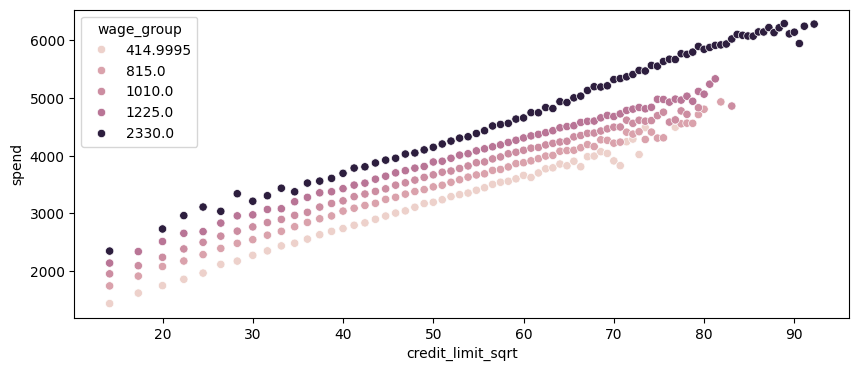

In [28]:
plt_df = (spend_data
          # apply the sqrt function to the treatment
         .assign(credit_limit_sqrt = np.sqrt(spend_data["credit_limit"]))
         # create 5 wage binds for better vizualization
         .assign(wage_group = pd.IntervalIndex(pd.qcut(spend_data["wage"],5)).mid)
         .groupby(["wage_group","credit_limit_sqrt"])[["spend"]].mean()
         .reset_index()
         )

plt.figure(figsize=(10,4))

sns.scatterplot(data=plt_df,
                x = "credit_limit_sqrt",
                y = "spend",
                hue = "wage_group")

plt.show()

In [29]:
model_spend = smf.ols(
    'spend ~ np.sqrt(credit_limit)', data=spend_data).fit()
model_spend.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,493.0044,6.501,75.832,0.000,480.262,505.747
np.sqrt(credit_limit),63.2525,0.122,519.268,0.000,63.014,63.491


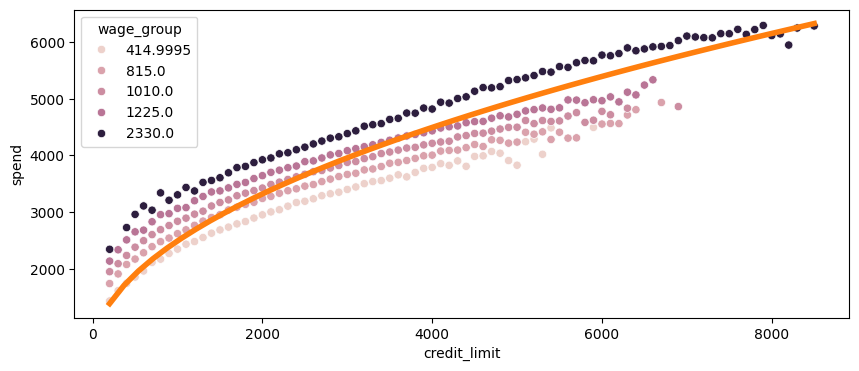

In [30]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"],5)).mid)
          .groupby(["wage_group","credit_limit"])[["spend"]].mean()
          .reset_index()
         )

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, 
         model_spend.params[0] + model_spend.params[1]*np.sqrt(x), 
         color = "C1",
         lw = 4)

sns.scatterplot(data = plt_df,
                x = "credit_limit",
                y = "spend",
                hue = "wage_group")
plt.show()

In [31]:
model_spend = smf.ols('spend ~ np.sqrt(credit_limit) + wage',
                      data = spend_data).fit()
model_spend.summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,383.5002,2.746,139.662,0.000,378.118,388.882
np.sqrt(credit_limit),43.8504,0.065,672.633,0.000,43.723,43.978
wage,1.0459,0.002,481.875,0.000,1.042,1.050


## Non-Linear FWL and Debiasing

In [32]:
# regress T(credit limit) on X(wage)
debias_spend_model = smf.ols('np.sqrt(credit_limit) ~ wage',
                           data=spend_data).fit()
# regress Y (spend) on X(wage)
denoise_spend_model = smf.ols('spend ~ wage',
                             data=spend_data).fit()

# get the residual of the T regression + avg of T (debias)
credit_limit_sqrt_deb = (debias_spend_model.resid +
                         np.sqrt(spend_data["credit_limit"]).mean())

# get the residual of the Y regression + avg of Y (denoise)
spend_den = (denoise_spend_model.resid +
             spend_data["spend"].mean())

# add the residual fields to the spend_data dataframe
spend_data_deb = (spend_data
                  .assign(credit_limit_sqrt_deb = credit_limit_sqrt_deb,
                          spend_den = spend_den))

final_model = smf.ols('spend_den ~ credit_limit_sqrt_deb',
                      data = spend_data_deb).fit()

final_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1493.6990,3.435,434.818,0.000,1486.966,1500.432
credit_limit_sqrt_deb,43.8504,0.065,672.640,0.000,43.723,43.978


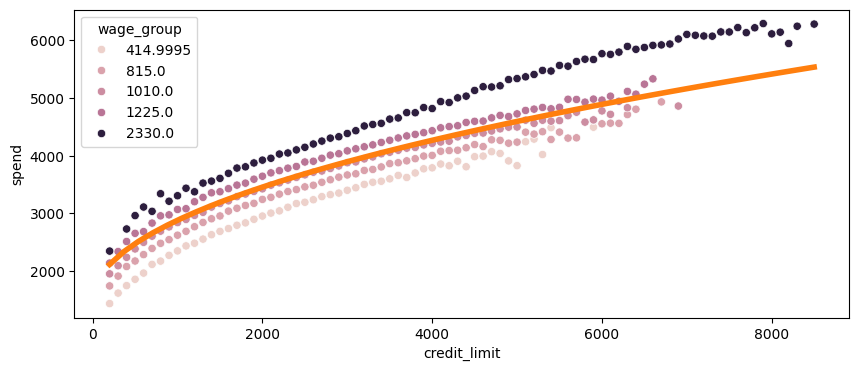

In [33]:
plt_df = (spend_data
          .assign(wage_group = lambda d: pd.IntervalIndex(pd.qcut(d["wage"],5)).mid)
          .groupby(["wage_group", "credit_limit"])[["spend"]].mean()
          .reset_index()
         )

x = np.linspace(plt_df["credit_limit"].min(), plt_df["credit_limit"].max())

plt.figure(figsize=(10,4))
plt.plot(x, (final_model.params[0] +
             final_model.params[1]*np.sqrt(x)),
         color = "C1", lw=4
        )

sns.scatterplot(data = plt_df,
               x = "credit_limit",
               y = "spend",
               hue = "wage_group")

plt.show()

In [34]:
final_model.params[1]

43.85039955107214

In [35]:
final_model.params[0]

1493.69899423099

In [36]:
x

array([ 200.        ,  369.3877551 ,  538.7755102 ,  708.16326531,
        877.55102041, 1046.93877551, 1216.32653061, 1385.71428571,
       1555.10204082, 1724.48979592, 1893.87755102, 2063.26530612,
       2232.65306122, 2402.04081633, 2571.42857143, 2740.81632653,
       2910.20408163, 3079.59183673, 3248.97959184, 3418.36734694,
       3587.75510204, 3757.14285714, 3926.53061224, 4095.91836735,
       4265.30612245, 4434.69387755, 4604.08163265, 4773.46938776,
       4942.85714286, 5112.24489796, 5281.63265306, 5451.02040816,
       5620.40816327, 5789.79591837, 5959.18367347, 6128.57142857,
       6297.95918367, 6467.34693878, 6636.73469388, 6806.12244898,
       6975.51020408, 7144.89795918, 7314.28571429, 7483.67346939,
       7653.06122449, 7822.44897959, 7991.83673469, 8161.2244898 ,
       8330.6122449 , 8500.        ])

In [37]:
plt_df["credit_limit"].min()

200.0

In [38]:
plt_df["credit_limit"].max()

8500.0

## Regression for Dummies
 
### Conditionally Random Experiments

In [39]:
risk_data_rnd = pd.read_csv('./data/risk_data_rnd.csv')
risk_data_rnd.head()

,wage,educ,exper,married,credit_score1,credit_score2,credit_score1_buckets,credit_limit,default
0,890.0,11,16,1,490.0,500.0,400,5400.0,0
1,670.0,11,7,1,196.0,481.0,200,3800.0,0
2,1220.0,14,9,1,392.0,611.0,400,5800.0,0
3,1210.0,15,8,1,627.0,519.0,600,6500.0,0
4,900.0,16,1,1,275.0,519.0,200,2100.0,0


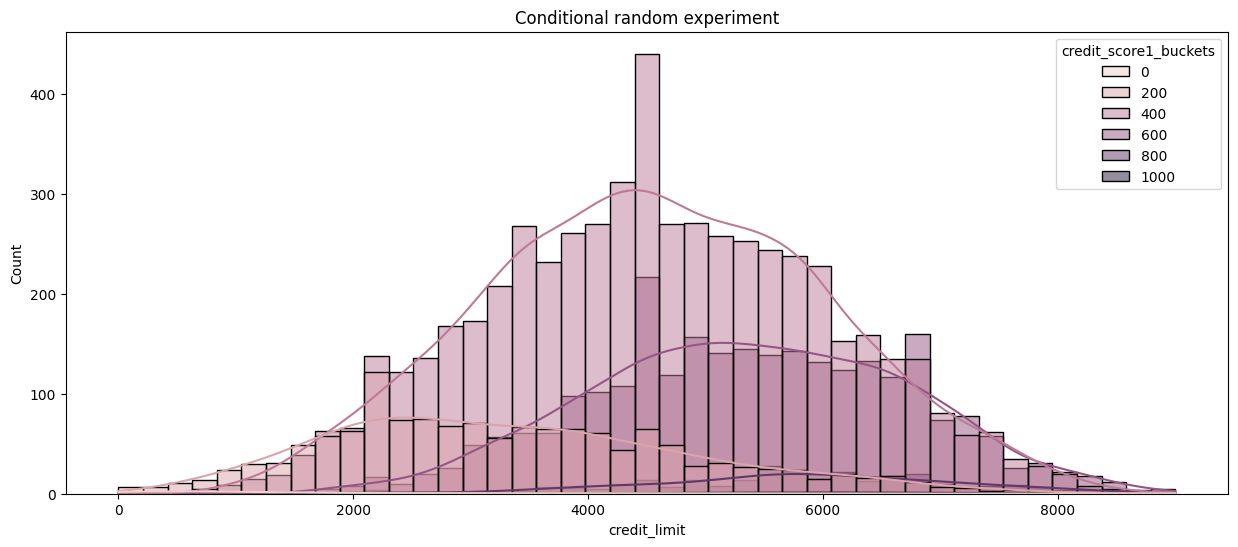

In [40]:
plt.figure(figsize=(15,6))
sns.histplot(data = risk_data_rnd,
             x = "credit_limit",
             hue = "credit_score1_buckets",
             kde = True)
plt.title("Conditional random experiment")
plt.show()

## Dummy Variables

In [41]:
model = smf.ols("default ~ credit_limit",
                data = risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1369,0.009,15.081,0.000,0.119,0.155
credit_limit,-9.344e-06,1.85e-06,-5.048,0.000,-1.3e-05,-5.72e-06


In [42]:
pd.set_option('display.max_columns', 9)

In [43]:
risk_data_dummies = (risk_data_rnd
                     .join(pd.get_dummies(risk_data_rnd["credit_score1_buckets"],
                                          prefix = "sb",
                                          drop_first=True)))
risk_data_dummies.head()

,wage,educ,exper,married,...,sb_400,sb_600,sb_800,sb_1000
0,890.0,11,16,1,...,True,False,False,False
1,670.0,11,7,1,...,False,False,False,False
2,1220.0,14,9,1,...,True,False,False,False
3,1210.0,15,8,1,...,False,True,False,False
4,900.0,16,1,1,...,False,False,False,False


In [44]:
formula = 'default ~ credit_limit+sb_200+sb_400+sb_600+sb_800+sb_1000'
model = smf.ols(formula, data = risk_data_dummies).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
sb_200[T.True],-0.0559,0.057,-0.981,0.327,-0.168,0.056
sb_400[T.True],-0.1442,0.057,-2.538,0.011,-0.256,-0.033
sb_600[T.True],-0.2148,0.057,-3.756,0.000,-0.327,-0.103
sb_800[T.True],-0.2489,0.060,-4.181,0.000,-0.366,-0.132
sb_1000[T.True],-0.2541,0.094,-2.715,0.007,-0.438,-0.071
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06


In [45]:
formula = 'default ~ credit_limit + C(credit_score1_buckets)'
model = smf.ols(formula, data = risk_data_rnd).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2253,0.056,4.000,0.000,0.115,0.336
C(credit_score1_buckets)[T.200],-0.0559,0.057,-0.981,0.327,-0.168,0.056
C(credit_score1_buckets)[T.400],-0.1442,0.057,-2.538,0.011,-0.256,-0.033
C(credit_score1_buckets)[T.600],-0.2148,0.057,-3.756,0.000,-0.327,-0.103
C(credit_score1_buckets)[T.800],-0.2489,0.060,-4.181,0.000,-0.366,-0.132
C(credit_score1_buckets)[T.1000],-0.2541,0.094,-2.715,0.007,-0.438,-0.071
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.97e-07,8.61e-06


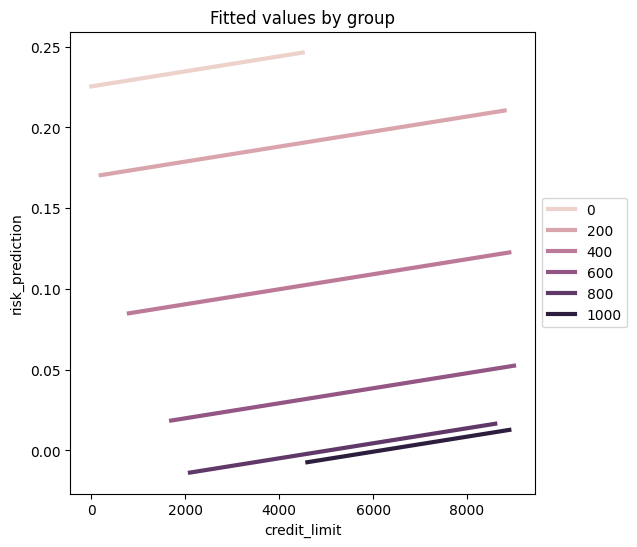

In [46]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
                   ["risk_prediction"].mean()
          .reset_index())

plt.figure(figsize=(6,6))
sns.lineplot(data=plt_df,
             x="credit_limit", 
             y="risk_prediction", 
             hue="credit_score1_buckets",
             lw=3)
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Saturated Regression Model

In [47]:
def regress(df, t, y):
    return smf.ols(f'{y}~{t}', data=df).fit().params[t]

effect_by_group = (risk_data_rnd
                   .groupby("credit_score1_buckets")
                   .apply(regress, y="default", t="credit_limit"))
effect_by_group

credit_score1_buckets
0      -0.000071
200     0.000007
400     0.000005
600     0.000003
800     0.000002
1000    0.000000
dtype: float64

In [48]:
group_size = risk_data_rnd.groupby("credit_score1_buckets").size()
ate = (effect_by_group * group_size).sum() / group_size.sum()
ate

4.490445628748727e-06

In [49]:
model = smf.ols('default ~ credit_limit * C(credit_score1_buckets)',
                 data = risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3137,0.077,4.086,0.000,0.163,0.464
C(credit_score1_buckets)[T.200],-0.1521,0.079,-1.926,0.054,-0.307,0.003
C(credit_score1_buckets)[T.400],-0.2339,0.078,-3.005,0.003,-0.386,-0.081
C(credit_score1_buckets)[T.600],-0.2957,0.080,-3.690,0.000,-0.453,-0.139
C(credit_score1_buckets)[T.800],-0.3227,0.111,-2.919,0.004,-0.539,-0.106
C(credit_score1_buckets)[T.1000],-0.3137,0.428,-0.733,0.464,-1.153,0.525
credit_limit,-7.072e-05,4.45e-05,-1.588,0.112,-0.000,1.66e-05
credit_limit:C(credit_score1_buckets)[T.200],7.769e-05,4.48e-05,1.734,0.083,-1.01e-05,0.000
credit_limit:C(credit_score1_buckets)[T.400],7.565e-05,4.46e-05,1.696,0.090,-1.18e-05,0.000
credit_limit:C(credit_score1_buckets)[T.600],7.398e-05,4.47e-05,1.655,0.098,-1.37e-05,0.000


In [50]:
(model.params[model.params.index.str.contains("credit_limit:")]
    + model.params["credit_limit"]).round(9)

credit_limit:C(credit_score1_buckets)[T.200]     0.000007
credit_limit:C(credit_score1_buckets)[T.400]     0.000005
credit_limit:C(credit_score1_buckets)[T.600]     0.000003
credit_limit:C(credit_score1_buckets)[T.800]     0.000002
credit_limit:C(credit_score1_buckets)[T.1000]   -0.000000
dtype: float64

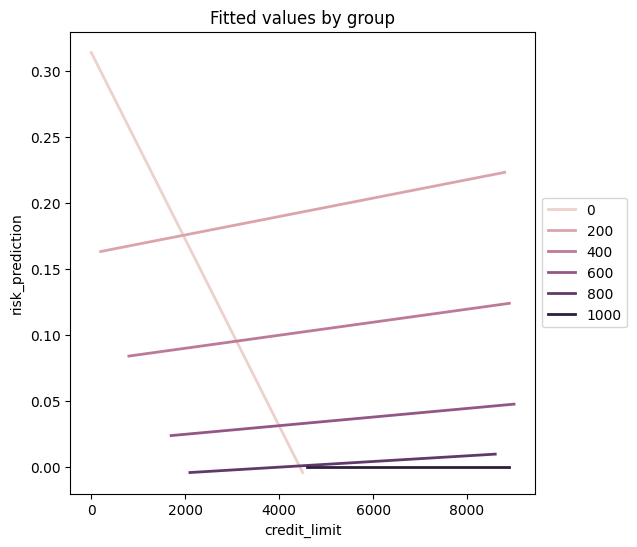

In [51]:
plt_df = (risk_data_rnd
          .assign(risk_prediction = model.fittedvalues)
          .groupby(["credit_limit", "credit_score1_buckets"])
          ["risk_prediction"]
          .mean()
          .reset_index())

plt.figure(figsize=(6,6))
sns.lineplot(data=plt_df,
             x="credit_limit", 
             y="risk_prediction", 
             hue="credit_score1_buckets",
             lw=2)
plt.title("Fitted values by group")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Regression as Variance Weighted Average

In [52]:
np.random.seed(123)

# std(t)-1
t1 = np.random.normal(0,1, size=1000)
df1 = pd.DataFrame(dict(
    t = t1,
    y=1*t1,
    g=1))

# std(t)-2
t2 = np.random.normal(0,2, size=500)
df2 = pd.DataFrame(dict(
    t=t2,
    y=2*t2,
    g=2))

df = pd.concat([df1,df2])
df.head()

,t,y,g
0,-1.085631,-1.085631,1
1,0.997345,0.997345,1
2,0.282978,0.282978,1
3,-1.506295,-1.506295,1
4,-0.578600,-0.578600,1


In [53]:
effect_by_group = df.groupby("g").apply(regress, y="y", t="t")
ate = (effect_by_group *
       df.groupby("g").size()).sum() / df.groupby("g").size().sum()
ate

1.3333333333333333

In [54]:
model = smf.ols("y ~ t + C(g)", data = df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0248,0.020,1.210,0.227,-0.015,0.065
C(g)[T.2],0.0199,0.035,0.559,0.576,-0.050,0.089
t,1.6258,0.013,129.986,0.000,1.601,1.650


In [55]:
model.params

Intercept    0.024758
C(g)[T.2]    0.019860
t            1.625775
dtype: float64

## De-Meaning and Fixed Effects

In [56]:
model_deb  = smf.ols('credit_limit ~ C(credit_score1_buckets)',
                     data = risk_data_rnd).fit()
model_deb.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1173.0769,278.994,4.205,0.000,626.193,1719.961
C(credit_score1_buckets)[T.200],2195.4337,281.554,7.798,0.000,1643.530,2747.337
C(credit_score1_buckets)[T.400],3402.3796,279.642,12.167,0.000,2854.224,3950.535
C(credit_score1_buckets)[T.600],4191.3235,280.345,14.951,0.000,3641.790,4740.857
C(credit_score1_buckets)[T.800],4639.5105,291.400,15.921,0.000,4068.309,5210.712
C(credit_score1_buckets)[T.1000],5006.9231,461.255,10.855,0.000,4102.771,5911.076


In [57]:
risk_data_rnd.groupby('credit_score1_buckets')["credit_limit"].mean()

credit_score1_buckets
0       1173.076923
200     3368.510638
400     4575.456498
600     5364.400448
800     5812.587413
1000    6180.000000
Name: credit_limit, dtype: float64

In [58]:
# The coefficients for the buckets above are the bucket average
# minus the first bucket (1173.076923)

In [59]:
risk_data_fe = risk_data_rnd.assign(
    credit_limit_avg = lambda d: (d
                                  .groupby("credit_score1_buckets")
                                  ["credit_limit"].transform("mean")))

In [60]:
model = smf.ols('default ~ I(credit_limit-credit_limit_avg)',
               data = risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.0935,0.003,32.121,0.000,0.088,0.099
I(credit_limit - credit_limit_avg),4.652e-06,2.05e-06,2.273,0.023,6.4e-07,8.66e-06


In [61]:
model = smf.ols('default ~ credit_limit + credit_limit_avg',
                data = risk_data_fe).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.4325,0.020,21.418,0.000,0.393,0.472
credit_limit,4.652e-06,2.02e-06,2.305,0.021,6.96e-07,8.61e-06
credit_limit_avg,-7.763e-05,4.75e-06,-16.334,0.000,-8.69e-05,-6.83e-05


## Omitted Variable Bias: Confounding Through the Lens of Regression

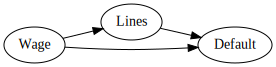

In [62]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("Lines","Default")
g.edge("Wage","Default")
g.edge("Wage","Lines")

g

In [63]:
short_model = smf.ols('default ~ credit_limit',
                      data = risk_data).fit()
short_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2192,0.004,59.715,0.000,0.212,0.226
credit_limit,-2.402e-05,1.16e-06,-20.689,0.000,-2.63e-05,-2.17e-05


In [64]:
short_model.params["credit_limit"]

-2.4019619925968688e-05

In [65]:
long_model = smf.ols('default ~ credit_limit + wage',
                     data=risk_data).fit()

omitted_model = smf.ols('wage ~ credit_limit',
                       data = risk_data).fit()

(long_model.params['credit_limit']
 + long_model.params['wage']*omitted_model.params['credit_limit'])

-2.401961992596868e-05

In [66]:
long_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2860,0.004,64.316,0.000,0.277,0.295
credit_limit,2.265e-06,1.53e-06,1.483,0.138,-7.29e-07,5.26e-06
wage,-0.0001,5.09e-06,-26.228,0.000,-0.000,-0.000


In [67]:
omitted_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,500.2341,3.206,156.026,0.000,493.950,506.518
credit_limit,0.1970,0.001,194.332,0.000,0.195,0.199


## Neutral Controls

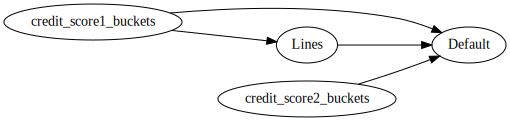

In [68]:
g = gr.Digraph(graph_attr={"rankdir":"LR"})

g.edge("credit_score1_buckets","Default")
g.edge("credit_score1_buckets","Lines")
g.edge("credit_score2_buckets","Default")
g.edge("Lines","Default")
g

In [69]:
formula = 'default ~ credit_limit + C(credit_score1_buckets) + credit_score2'
model = smf.ols(formula, data = risk_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.5576,0.055,10.132,0.000,0.450,0.665
C(credit_score1_buckets)[T.200],-0.0387,0.055,-0.710,0.478,-0.146,0.068
C(credit_score1_buckets)[T.400],-0.1032,0.054,-1.898,0.058,-0.210,0.003
C(credit_score1_buckets)[T.600],-0.1410,0.055,-2.574,0.010,-0.248,-0.034
C(credit_score1_buckets)[T.800],-0.1161,0.057,-2.031,0.042,-0.228,-0.004
C(credit_score1_buckets)[T.1000],-0.0430,0.090,-0.479,0.632,-0.219,0.133
credit_limit,4.928e-06,1.93e-06,2.551,0.011,1.14e-06,8.71e-06
credit_score2,-0.0007,2.34e-05,-30.225,0.000,-0.001,-0.001


## Noise Inducing Control

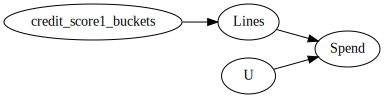

In [70]:
g = gr.Digraph(graph_attr={'rankdir':'LR'})

g.edge('credit_score1_buckets','Lines')
g.edge('U','Spend')
g.edge('Lines','Spend')
g

In [71]:
spend_data_rnd = pd.read_csv('./data/spend_data_rnd.csv')
spend_data_rnd.head()

,wage,educ,exper,married,credit_score1,credit_score1_buckets,credit_limit,spend
0,890.0,11,16,1,533.0,600,6900.0,3144
1,640.0,11,7,1,467.0,400,4600.0,3054
2,1160.0,14,9,1,600.0,600,5100.0,3668
3,1180.0,15,8,1,633.0,600,6200.0,2792
4,920.0,16,1,1,733.0,800,5900.0,3140


In [72]:
model = smf.ols('spend ~ np.sqrt(credit_limit)',
               data = spend_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2153.2154,218.600,9.850,0.000,1723.723,2582.708
np.sqrt(credit_limit),16.2915,2.988,5.452,0.000,10.420,22.163


In [73]:
model = smf.ols('spend~np.sqrt(credit_limit) + C(credit_score1_buckets)',
                data = spend_data_rnd).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2367.4867,556.273,4.256,0.000,1274.528,3460.446
C(credit_score1_buckets)[T.200],-144.7921,591.613,-0.245,0.807,-1307.185,1017.601
C(credit_score1_buckets)[T.400],-118.3923,565.364,-0.209,0.834,-1229.211,992.427
C(credit_score1_buckets)[T.600],-111.5738,570.471,-0.196,0.845,-1232.429,1009.281
C(credit_score1_buckets)[T.800],-89.7366,574.645,-0.156,0.876,-1218.791,1039.318
C(credit_score1_buckets)[T.1000],363.8990,608.014,0.599,0.550,-830.720,1558.518
np.sqrt(credit_limit),14.5953,3.523,4.142,0.000,7.673,21.518


### Feature Selection: A Bias-Variance Trade-Off

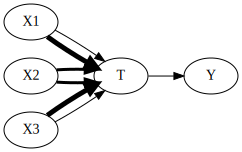

In [74]:
g = gr.Digraph(graph_attr={'rankdir':'LR'})
g.edge('X1','T', penwidth='5')
g.edge('X2','T', penwidth='3')
g.edge('X3','T', penwidth='1')

g.edge('X1','T', penwidth='1')
g.edge('X2','T', penwidth='3')
g.edge('X3','T', penwidth='5')

g.edge('T','Y')

g

In [75]:
np.random.seed(123)

n=100
(x1,x2,x3) = (np.random.normal(0,1,n) for _ in range(3))
t = np.random.normal(10*x1 + 5*x2 + x3)

#ate=0.05
y = np.random.normal(0.05*t + x1 + 5*x2 + 10*x3, 5)
df = pd.DataFrame(dict(y=y, t=t, x2=x2, x3=x3))

smf.ols('y~t+x1+x2+x3', data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.2707,0.527,0.514,0.608,-0.775,1.316
t,0.8664,0.607,1.427,0.157,-0.339,2.072
x1,-7.0628,6.038,-1.170,0.245,-19.049,4.923
x2,0.0143,3.128,0.005,0.996,-6.195,6.224
x3,9.6292,0.887,10.861,0.000,7.869,11.389


In [76]:
smf.ols('y~t+x2+x3',data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1889,0.523,0.361,0.719,-0.849,1.227
t,0.1585,0.046,3.410,0.001,0.066,0.251
x2,3.6095,0.582,6.197,0.000,2.453,4.766
x3,10.4549,0.537,19.453,0.000,9.388,11.522


## Keys